# EDA OF ONLINE FOOD DELIVERY CUSTOMERS DATASET 

#### import necessary libraries

In [11]:
import numpy as np
import pandas as pd
import seaborn as sns          #for visualization
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils import class_weight
import xgboost as xgb

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
%matplotlib inline     

import warnings
warnings.filterwarnings('ignore')

### Import the dataset as pandas dataframe

In [12]:
df = pd.read_csv("./food_delivery_churn_dataset.csv")

In [13]:
df.head()

,Customer_ID,Orders_Last_3_Months,Avg_Order_Value,App_Opens_Per_Week,Complaints,Used_Offers,Last_Order_Date,Membership,Is_Churned
0,101,6,₹432,7,1,Yes,2025-06-05,No,0
1,102,1,₹532,13,2,No,2024-06-27,Yes,0
2,103,8,₹433,14,0,Yes,2024-11-29,Yes,0
3,104,3,₹499,4,0,Yes,2025-04-25,Yes,0
4,105,9,₹260,14,1,No,2024-08-11,Yes,0


#### Lists the columns names

In [14]:
df.columns

Index(['Customer_ID', 'Orders_Last_3_Months', 'Avg_Order_Value',
       'App_Opens_Per_Week', 'Complaints', 'Used_Offers', 'Last_Order_Date',
       'Membership', 'Is_Churned'],
      dtype='object')

In [15]:
df.tail()

,Customer_ID,Orders_Last_3_Months,Avg_Order_Value,App_Opens_Per_Week,Complaints,Used_Offers,Last_Order_Date,Membership,Is_Churned
495,596,1,₹562,1,0,Yes,2024-12-06,Yes,1
496,597,5,₹501,8,2,Yes,2024-12-14,No,0
497,598,8,₹343,7,1,No,2025-06-09,No,0
498,599,5,₹573,7,1,No,2024-10-10,Yes,0
499,600,4,₹324,13,0,Yes,2024-11-07,No,0


#### Shape of dataset

In [16]:
df.shape

(500, 9)

#### Information about dataset

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Customer_ID           500 non-null    int64 
 1   Orders_Last_3_Months  500 non-null    int64 
 2   Avg_Order_Value       500 non-null    object
 3   App_Opens_Per_Week    500 non-null    int64 
 4   Complaints            500 non-null    int64 
 5   Used_Offers           500 non-null    object
 6   Last_Order_Date       500 non-null    object
 7   Membership            500 non-null    object
 8   Is_Churned            500 non-null    int64 
dtypes: int64(5), object(4)
memory usage: 35.3+ KB


#### “How many customers churned?”

In [18]:
churned_count = df[df['Is_Churned'] == 1].shape[0]
print(f"Total Churned Customers: {churned_count}")


Total Churned Customers: 54


In [19]:
total_customers = df.shape[0]
print(f"Total Customers: {total_customers}")

churn_percentage = (churned_count / total_customers) * 100
print(f"Churn Rate: {churn_percentage:.2f}%")


Total Customers: 500
Churn Rate: 10.80%


#### Now let's build a prediction model

### DataChecks to Perform on Dataset

#### 1. Check missing values

In [20]:
df.isna().sum()

Customer_ID             0
Orders_Last_3_Months    0
Avg_Order_Value         0
App_Opens_Per_Week      0
Complaints              0
Used_Offers             0
Last_Order_Date         0
Membership              0
Is_Churned              0
dtype: int64

In [21]:

# Numerical columns (int, float)
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Categorical columns (object, category)
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Print them
print("Numerical Columns:")
print(numerical_cols)

print("\nCategorical Columns:")
print(categorical_cols)

Numerical Columns:
['Customer_ID', 'Orders_Last_3_Months', 'App_Opens_Per_Week', 'Complaints', 'Is_Churned']

Categorical Columns:
['Avg_Order_Value', 'Used_Offers', 'Last_Order_Date', 'Membership']


In [22]:
df.describe()

,Customer_ID,Orders_Last_3_Months,App_Opens_Per_Week,Complaints,Is_Churned
count,500.000000,500.000000,500.00000,500.000000,500.000000
mean,350.500000,5.130000,7.54400,1.018000,0.108000
std,144.481833,2.246596,3.99098,1.017717,0.310691
min,101.000000,0.000000,1.00000,0.000000,0.000000
25%,225.750000,4.000000,4.00000,0.000000,0.000000
50%,350.500000,5.000000,7.50000,1.000000,0.000000
75%,475.250000,7.000000,11.00000,2.000000,0.000000
max,600.000000,11.000000,14.00000,5.000000,1.000000


In [23]:
# First, select the categorical columns
categorical_vars = df.select_dtypes(include=['object', 'category'])

# Now, display unique values for each categorical column
for col in categorical_vars.columns:
    print(f"\nUnique values in '{col}':")
    print(df[col].unique())



Unique values in 'Avg_Order_Value':
['₹432' '₹532' '₹433' '₹499' '₹260' '₹425' '₹345' '₹430' '₹405' '₹546'
 '₹168' '₹554' '₹408' '₹242' '₹373' '₹463' '₹596' '₹300' '₹440' '₹600'
 '₹569' '₹338' '₹438' '₹464' '₹453' '₹434' '₹480' '₹448' '₹214' '₹198'
 '₹584' '₹301' '₹274' '₹517' '₹548' '₹175' '₹549' '₹519' '₹382' '₹529'
 '₹304' '₹166' '₹179' '₹512' '₹520' '₹595' '₹219' '₹285' '₹577' '₹487'
 '₹560' '₹586' '₹227' '₹190' '₹229' '₹488' '₹210' '₹539' '₹263' '₹332'
 '₹207' '₹273' '₹157' '₹344' '₹295' '₹217' '₹353' '₹541' '₹347' '₹445'
 '₹352' '₹419' '₹497' '₹238' '₹193' '₹211' '₹201' '₹253' '₹589' '₹249'
 '₹437' '₹222' '₹162' '₹403' '₹258' '₹481' '₹398' '₹409' '₹391' '₹599'
 '₹340' '₹411' '₹533' '₹356' '₹386' '₹568' '₹369' '₹416' '₹277' '₹324'
 '₹343' '₹475' '₹316' '₹289' '₹192' '₹478' '₹518' '₹151' '₹593' '₹547'
 '₹354' '₹333' '₹457' '₹317' '₹215' '₹378' '₹544' '₹565' '₹412' '₹460'
 '₹220' '₹341' '₹415' '₹506' '₹591' '₹392' '₹498' '₹342' '₹247' '₹239'
 '₹189' '₹311' '₹521' '₹428' '₹451' '₹38

#### Now we will remove the rs sign from avg order value and mke it integer

In [24]:
df['Avg_Order_Value'] = df['Avg_Order_Value'].str.replace('₹', '').astype(int)

#### Verify it 

In [25]:
# First, select the categorical columns
categorical_vars = df.select_dtypes(include=['object', 'category'])

# Now, display unique values for each categorical column
for col in categorical_vars.columns:
    print(f"\nUnique values in '{col}':")
    print(df[col].unique())



Unique values in 'Used_Offers':
['Yes' 'No']

Unique values in 'Last_Order_Date':
['2025-06-05' '2024-06-27' '2024-11-29' '2025-04-25' '2024-08-11'
 '2024-07-22' '2025-06-10' '2024-10-22' '2024-11-06' '2024-07-16'
 '2024-09-23' '2024-07-29' '2024-06-18' '2025-05-22' '2024-10-06'
 '2025-03-27' '2025-01-11' '2025-02-15' '2025-03-29' '2024-08-08'
 '2024-07-18' '2024-12-01' '2025-05-02' '2025-03-18' '2025-05-01'
 '2025-03-25' '2025-01-31' '2024-11-24' '2025-04-10' '2025-02-16'
 '2024-07-23' '2024-09-25' '2025-02-23' '2025-04-27' '2025-04-03'
 '2024-11-12' '2024-06-16' '2024-08-29' '2025-03-15' '2025-03-22'
 '2025-01-20' '2024-12-21' '2024-09-30' '2025-02-18' '2025-05-31'
 '2024-12-28' '2025-05-27' '2025-03-26' '2024-12-31' '2024-11-26'
 '2025-02-25' '2024-11-14' '2025-01-30' '2025-03-07' '2024-08-30'
 '2024-07-10' '2024-06-28' '2025-03-28' '2024-12-23' '2024-08-13'
 '2024-11-04' '2025-04-06' '2025-04-01' '2025-05-06' '2024-06-15'
 '2024-08-09' '2025-03-24' '2025-04-19' '2025-01-19' '2024-

#### map 0 and 1 for yes and no in categorcal cols like  used offers and membership

In [26]:
df['Used_Offers'] = df['Used_Offers'].map({'Yes': 1, 'No': 0})

df['Membership'] = df['Membership'].map({'Yes': 1, 'No': 0})


In [27]:
df


,Customer_ID,Orders_Last_3_Months,Avg_Order_Value,App_Opens_Per_Week,Complaints,Used_Offers,Last_Order_Date,Membership,Is_Churned
0,101,6,432,7,1,1,2025-06-05,0,0
1,102,1,532,13,2,0,2024-06-27,1,0
2,103,8,433,14,0,1,2024-11-29,1,0
3,104,3,499,4,0,1,2025-04-25,1,0
4,105,9,260,14,1,0,2024-08-11,1,0
...,...,...,...,...,...,...,...,...,...
495,596,1,562,1,0,1,2024-12-06,1,1
496,597,5,501,8,2,1,2024-12-14,0,0
497,598,8,343,7,1,0,2025-06-09,0,0
498,599,5,573,7,1,0,2024-10-10,1,0


In [28]:
# First, select the categorical columns
categorical_vars = df.select_dtypes(include=['object', 'category'])

# Now, display unique values for each categorical column
for col in categorical_vars.columns:
    print(f"\nUnique values in '{col}':")
    print(df[col].unique())



Unique values in 'Last_Order_Date':
['2025-06-05' '2024-06-27' '2024-11-29' '2025-04-25' '2024-08-11'
 '2024-07-22' '2025-06-10' '2024-10-22' '2024-11-06' '2024-07-16'
 '2024-09-23' '2024-07-29' '2024-06-18' '2025-05-22' '2024-10-06'
 '2025-03-27' '2025-01-11' '2025-02-15' '2025-03-29' '2024-08-08'
 '2024-07-18' '2024-12-01' '2025-05-02' '2025-03-18' '2025-05-01'
 '2025-03-25' '2025-01-31' '2024-11-24' '2025-04-10' '2025-02-16'
 '2024-07-23' '2024-09-25' '2025-02-23' '2025-04-27' '2025-04-03'
 '2024-11-12' '2024-06-16' '2024-08-29' '2025-03-15' '2025-03-22'
 '2025-01-20' '2024-12-21' '2024-09-30' '2025-02-18' '2025-05-31'
 '2024-12-28' '2025-05-27' '2025-03-26' '2024-12-31' '2024-11-26'
 '2025-02-25' '2024-11-14' '2025-01-30' '2025-03-07' '2024-08-30'
 '2024-07-10' '2024-06-28' '2025-03-28' '2024-12-23' '2024-08-13'
 '2024-11-04' '2025-04-06' '2025-04-01' '2025-05-06' '2024-06-15'
 '2024-08-09' '2025-03-24' '2025-04-19' '2025-01-19' '2024-10-30'
 '2024-09-13' '2024-10-08' '2025-01-12'

#### Now only last order date is the categorical column left
#### we will find days since last order through this column. First convert the datatype to datetime as it is object

In [29]:
df['Last_Order_Date'] = pd.to_datetime(df['Last_Order_Date'])


In [30]:
# Calculate days since last order
working_date = pd.to_datetime('2025-06-03')  # Fixed date
df['Days_Since_Last_Order'] = (working_date - df['Last_Order_Date']).dt.days


In [31]:
print(df)

     Customer_ID  Orders_Last_3_Months  Avg_Order_Value  App_Opens_Per_Week  \
0            101                     6              432                   7   
1            102                     1              532                  13   
2            103                     8              433                  14   
3            104                     3              499                   4   
4            105                     9              260                  14   
..           ...                   ...              ...                 ...   
495          596                     1              562                   1   
496          597                     5              501                   8   
497          598                     8              343                   7   
498          599                     5              573                   7   
499          600                     4              324                  13   

     Complaints  Used_Offers Last_Order_Date  Membe

## Visualization

In [32]:
print(df['Is_Churned'].value_counts())

Is_Churned
0    446
1     54
Name: count, dtype: int64


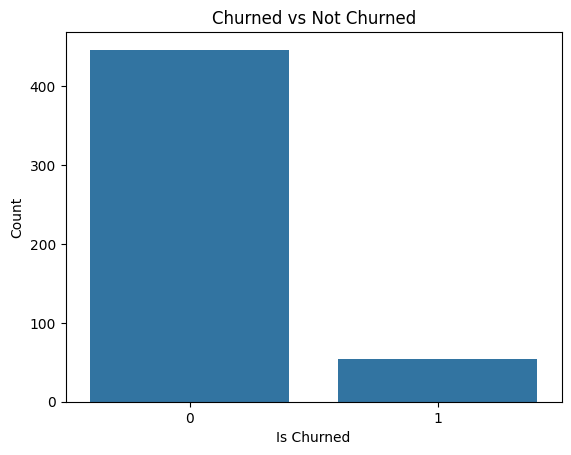

In [33]:
sns.countplot(x='Is_Churned', data=df)
plt.title("Churned vs Not Churned")
plt.xlabel("Is Churned")
plt.ylabel("Count")
plt.show()

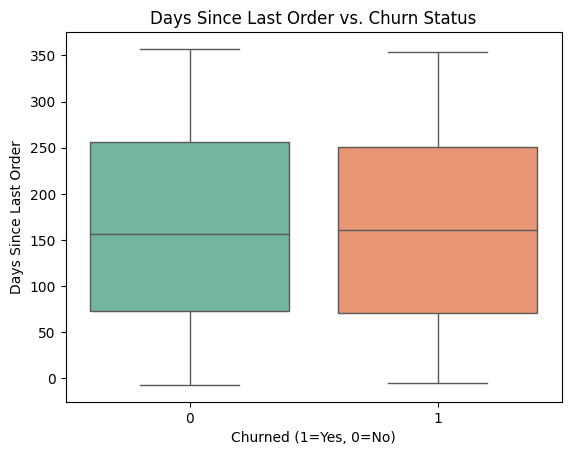

In [34]:
sns.boxplot(x='Is_Churned', y='Days_Since_Last_Order', data=df, palette=['#66c2a5','#fc8d62'])
plt.title('Days Since Last Order vs. Churn Status')
plt.xlabel('Churned (1=Yes, 0=No)')
plt.ylabel('Days Since Last Order')
plt.show()

#### the median line (Q2) for Churn=1 is higher than for Churn=0, it confirms that inactive customers are more likely to churn
#### Higher days since last order = Higher churn risk
#### The boxplot shows a strong positive relationship between customers who haven't ordered in longer periods (200+ days) are more likely to churn.

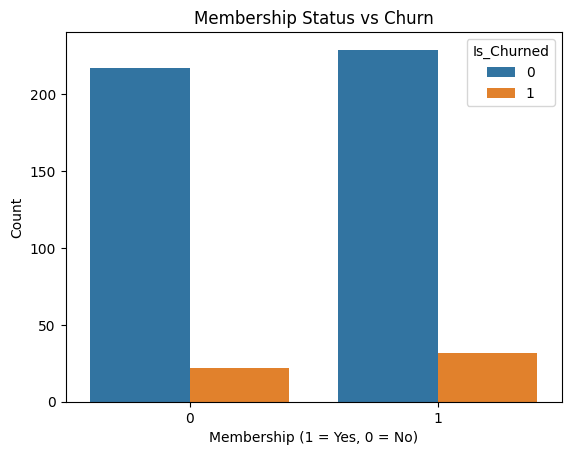

In [35]:
sns.countplot(x='Membership', hue='Is_Churned', data=df)
plt.title("Membership Status vs Churn")
plt.xlabel("Membership (1 = Yes, 0 = No)")
plt.ylabel("Count")
plt.show()


#### Membership does not show any significant effect on the churn rate

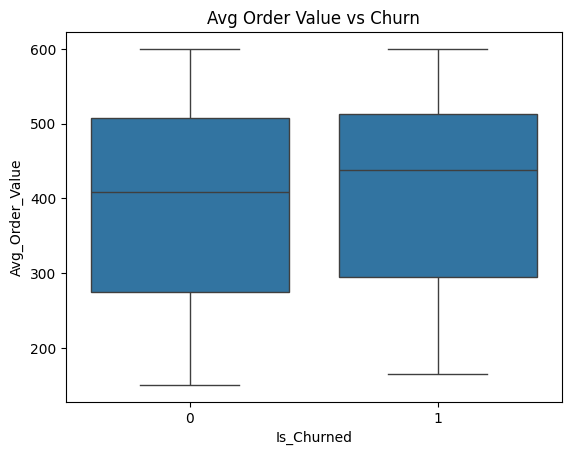

In [36]:
sns.boxplot(x='Is_Churned', y='Avg_Order_Value', data=df)
plt.title("Avg Order Value vs Churn")
plt.show()


#### Insights
#### Non-Churned Customers (0) have Higher Median their Spend is about to 400
#### Churned Customers (1) have Lower Median their spend is slightly greater than 300
#### So,   Low spenders are more likely to churn
####    Customers who spend more are retained longer.

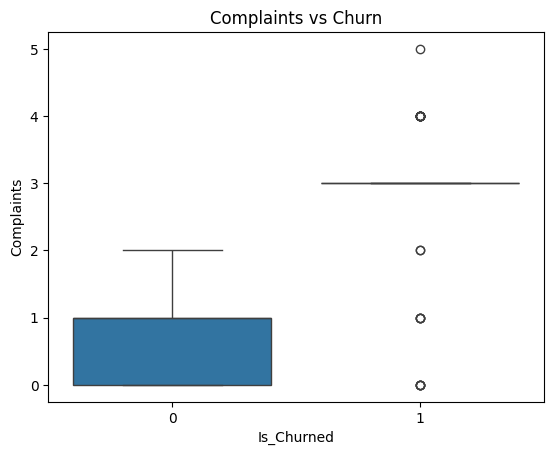

In [37]:
sns.boxplot(x='Is_Churned', y='Complaints', data=df)
plt.title("Complaints vs Churn")
plt.show()

### Insights
#### Non-Churned Customers i.e Is_Churned = 0 have low median complaints close to 0-1 and also the IQR is narrow i.e 0-2 complaints. So it is observed that Customers with lesser complaints are more likely to stay
#### For, Churned Customers i.e Is_Churned = 1 have High Median Complaints close to 3-4 and also they have Wider IQR: Spread from 1-5 complaints So, Customers who churn often have more complaints.

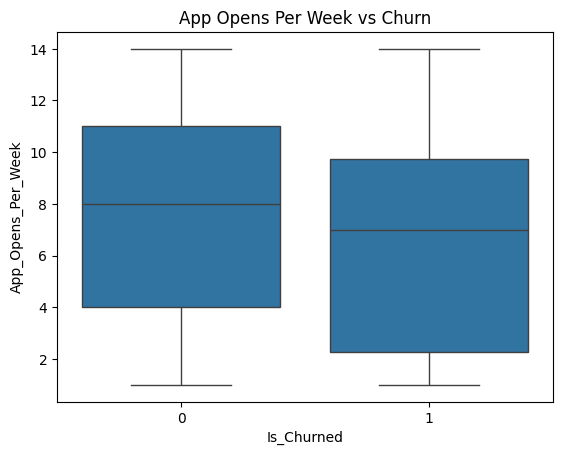

In [38]:
sns.boxplot(x='Is_Churned', y='App_Opens_Per_Week', data=df)
plt.title("App Opens Per Week vs Churn")
plt.show()


#### Insights :
####  Active app users are retained customers.
####  Low app engagement predicts churn.



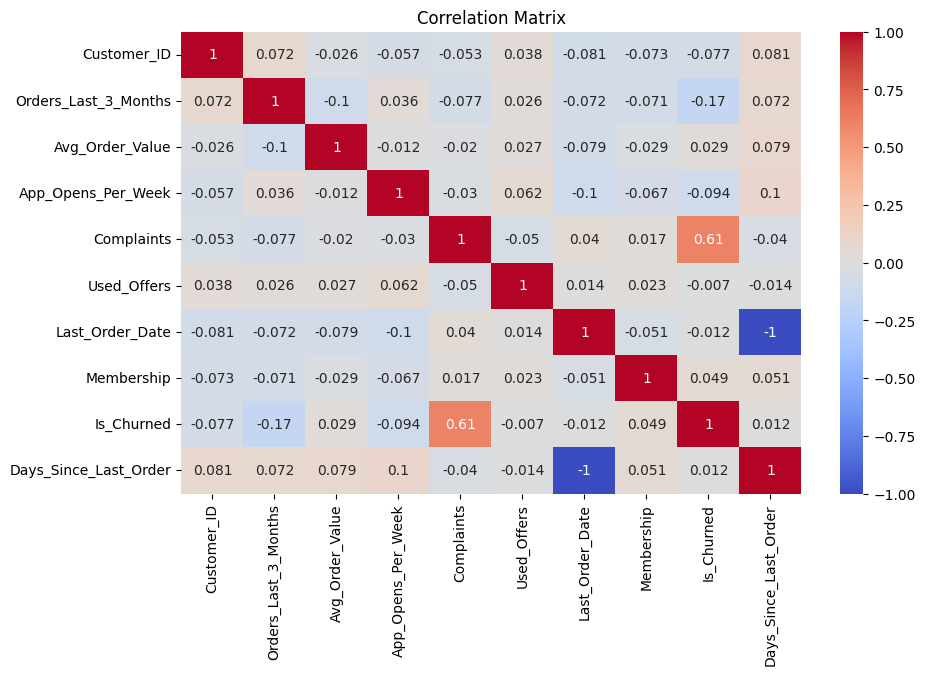

In [39]:
plt.figure(figsize=(10, 6))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


#### Complaints is the most important churn indicator — people who complain more tend to churn.

#### App_Opens_Per_Week and Orders_Last_3_Months are negatively correlated with churn — less engagement means more churn.

#### Most other features have very weak or no correlation with churn.

####  -1 correlation between Last_Order_Date and Days_Since_Last_Order indicate a perfect negative correlation, as                      Last_Order_Date increases (more recent), Days_Since_Last_Order decreases.

In [40]:
correlation_matrix = df.corr(numeric_only=True)

churn_corr = correlation_matrix['Is_Churned'].sort_values(ascending=False)

print("Correlation with Is_Churned:")
print(churn_corr)

Correlation with Is_Churned:
Is_Churned               1.000000
Complaints               0.608613
Membership               0.049174
Avg_Order_Value          0.028958
Days_Since_Last_Order    0.011646
Used_Offers             -0.006961
Customer_ID             -0.076519
App_Opens_Per_Week      -0.094346
Orders_Last_3_Months    -0.169451
Name: Is_Churned, dtype: float64


### Define features and target
### and split the dataset into train and test 

In [86]:

# Define features and target
features = [
    'Orders_Last_3_Months', 'Avg_Order_Value', 'App_Opens_Per_Week',
    'Complaints', 'Used_Offers', 'Membership', 'Days_Since_Last_Order'
]
X = df[features]
y = df['Is_Churned']


In [87]:

# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42   # use stratify for maintaining the ratio of orginal dataset 80/20
)

## 1 Logistic Regression

In [88]:

# Calculate class weights
weights = class_weight.compute_class_weight('balanced', 
                                         classes=np.unique(Y_train), 
                                         y=Y_train)
class_weights = dict(zip(np.unique(Y_train), weights))

# Train model with class weights
log_model = LogisticRegression(max_iter=1000, 
                             class_weight=class_weights,
                             random_state=42)
log_model.fit(X_train, Y_train)

# Make predictions
y_pred = log_model.predict(X_test)


print("Confusion Matrix:\n", confusion_matrix(Y_test, y_pred))
print("\nClassification Report:\n", classification_report(Y_test, y_pred))
print("Accuracy Score:", accuracy_score(Y_test, y_pred))


Confusion Matrix:
 [[74 15]
 [ 3  8]]

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.83      0.89        89
           1       0.35      0.73      0.47        11

    accuracy                           0.82       100
   macro avg       0.65      0.78      0.68       100
weighted avg       0.89      0.82      0.85       100

Accuracy Score: 0.82


## 2.Random Forest

In [89]:

# Model training
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, Y_train)

# Prediction
y_pred = model.predict(X_test)

# Print Evaluation Metrics
print("Confusion Matrix:\n", confusion_matrix(Y_test, y_pred))
print("\nClassification Report:\n", classification_report(Y_test, y_pred))
print("Accuracy Score:", accuracy_score(Y_test, y_pred))


Confusion Matrix:
 [[89  0]
 [ 2  9]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99        89
           1       1.00      0.82      0.90        11

    accuracy                           0.98       100
   macro avg       0.99      0.91      0.94       100
weighted avg       0.98      0.98      0.98       100

Accuracy Score: 0.98


## XGBoost 

In [112]:
pip install xgboost==1.6.2


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.9/255.9 MB 185.1 kB/s eta 0:00:00m eta 0:00:0136m0:00:07m
  Attempting uninstall: xgboost
    Found existing installation: xgboost 3.0.2
    Uninstalling xgboost-3.0.2:
      Successfully uninstalled xgboost-3.0.2
Note: you may need to restart the kernel to use updated packages.


In [90]:

print(X_test.isnull().sum())


Orders_Last_3_Months     0
Avg_Order_Value          0
App_Opens_Per_Week       0
Complaints               0
Used_Offers              0
Membership               0
Days_Since_Last_Order    0
dtype: int64


In [91]:
print(Y_train.unique())
print(Y_train.dtype)


[1 0]
int64


In [92]:


# Convert dtypes
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
Y_train = Y_train.astype(np.int32)
Y_test = Y_test.astype(np.int32)

# Initialize and train XGBoost model
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train, Y_train)

# Predict and evaluate
y_pred = xgb_model.predict(X_test)

print("Confusion Matrix:\n", confusion_matrix(Y_test, y_pred))
print("\nClassification Report:\n", classification_report(Y_test, y_pred, target_names=["Not Churned", "Churned"]))


Confusion Matrix:
 [[89  0]
 [ 0 11]]

Classification Report:
               precision    recall  f1-score   support

 Not Churned       1.00      1.00      1.00        89
     Churned       1.00      1.00      1.00        11

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



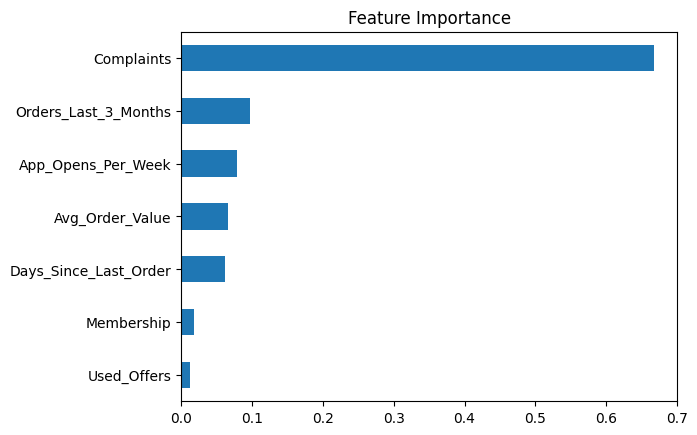

In [93]:
# as the accuracy is 1.0 so validate it by checking if there's no data leakage find the feature importance
feature_importance = pd.Series(model.feature_importances_, index=features)
feature_importance.sort_values().plot(kind='barh',title="Feature Importance")
plt.show()

In [94]:
# Check if any feature perfectly predicts the target
from sklearn.feature_selection import mutual_info_classif
mutual_info = mutual_info_classif(X_train, Y_train)
print(pd.Series(mutual_info, index=X_train.columns).sort_values(ascending=False))

Complaints               0.249305
Orders_Last_3_Months     0.004053
Days_Since_Last_Order    0.001482
App_Opens_Per_Week       0.000000
Avg_Order_Value          0.000000
Used_Offers              0.000000
Membership               0.000000
dtype: float64


#### no feature is closely related to 1.0 so no feature is perfectly predicting the target

In [95]:
print(Y_train.value_counts())  # Check class distribution

Is_Churned
0    357
1     43
Name: count, dtype: int64


#### This shows that our classes are imbalanced because the churned customers are 357 and not churned are 43 only so we need to balance them 

#### let's try doing sampling we will use smote here

In [96]:
df


,Customer_ID,Orders_Last_3_Months,Avg_Order_Value,App_Opens_Per_Week,Complaints,Used_Offers,Last_Order_Date,Membership,Is_Churned,Days_Since_Last_Order
0,101,6,432,7,1,1,2025-06-05,0,0,-2
1,102,1,532,13,2,0,2024-06-27,1,0,341
2,103,8,433,14,0,1,2024-11-29,1,0,186
3,104,3,499,4,0,1,2025-04-25,1,0,39
4,105,9,260,14,1,0,2024-08-11,1,0,296
...,...,...,...,...,...,...,...,...,...,...
495,596,1,562,1,0,1,2024-12-06,1,1,179
496,597,5,501,8,2,1,2024-12-14,0,0,171
497,598,8,343,7,1,0,2025-06-09,0,0,-6
498,599,5,573,7,1,0,2024-10-10,1,0,236


In [97]:
df = df.drop(['Customer_ID', 'Last_Order_Date'], axis=1)


In [98]:
df


,Orders_Last_3_Months,Avg_Order_Value,App_Opens_Per_Week,Complaints,Used_Offers,Membership,Is_Churned,Days_Since_Last_Order
0,6,432,7,1,1,0,0,-2
1,1,532,13,2,0,1,0,341
2,8,433,14,0,1,1,0,186
3,3,499,4,0,1,1,0,39
4,9,260,14,1,0,1,0,296
...,...,...,...,...,...,...,...,...
495,1,562,1,0,1,1,1,179
496,5,501,8,2,1,0,0,171
497,8,343,7,1,0,0,0,-6
498,5,573,7,1,0,1,0,236


In [99]:
!pip install -q imbalanced-learn
from imblearn.over_sampling import SMOTE


In [106]:

from collections import Counter   # to count the class values before an after smote

# Split into X and y
X = df.drop('Is_Churned', axis=1)
y = df['Is_Churned']

# Train/test split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

#check classes count before smote
print("Before SMOTE:", Counter(Y_train))


# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_bal, Y_train_bal = smote.fit_resample(X_train, Y_train)

# Print class distribution after SMOTE
print("After SMOTE:", Counter(Y_train_bal))

# Train model
model = RandomForestClassifier(random_state=42)
model.fit(X_train_bal, Y_train_bal)

# Evaluate
y_pred = model.predict(X_test)
print("\nConfusion Matrix:\n", confusion_matrix(Y_test, y_pred))
print("\nClassification Report:\n", classification_report(Y_test, y_pred))
print("Accuracy Score:", accuracy_score(Y_test, y_pred))



Before SMOTE: Counter({0: 357, 1: 43})
After SMOTE: Counter({1: 357, 0: 357})

Confusion Matrix:
 [[89  0]
 [ 0 11]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        89
           1       1.00      1.00      1.00        11

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

Accuracy Score: 1.0


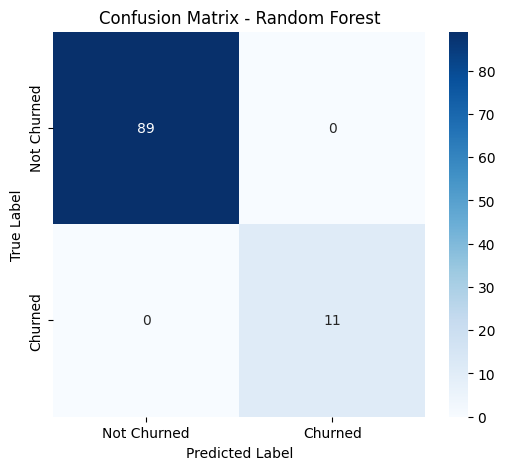

In [107]:

# Create confusion matrix
cm = confusion_matrix(Y_test, y_pred)
labels = ['Not Churned', 'Churned']

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

####  True Negatives (TN): 89 customers correctly predicted as not churned

#### True Positives (TP): 11 customers correctly predicted as churned

#### False Negatives (FN): 0 (no) churned customer missed

#### False Positives (FP): 0 (no) non-churned customer wrongly predicted as churned

### Doing Sampling gave us more accurate result avoiding overfitting.

####  Train Logistic Regression model on sampled data


In [108]:

model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_bal, Y_train_bal)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate model
print("\nConfusion Matrix:\n", confusion_matrix(Y_test, y_pred))
print("\nClassification Report:\n", classification_report(Y_test, y_pred))
print("Accuracy Score:", accuracy_score(Y_test, y_pred))



Confusion Matrix:
 [[79 10]
 [ 4  7]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.89      0.92        89
           1       0.41      0.64      0.50        11

    accuracy                           0.86       100
   macro avg       0.68      0.76      0.71       100
weighted avg       0.89      0.86      0.87       100

Accuracy Score: 0.86
